In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report, balanced_accuracy_score
from ProteinDataset import ProteinDataset
from utils.config import CFG
from utils.dataset_utils import load_csv, rawdata_to_df, preprocess_data
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
full_dataset = preprocess_data(rawdata_to_df(), CFG.num_classes + 1)
ds = ProteinDataset(full_dataset)

embeddings = list(map(lambda x: ds._create_embedding(x), ds.data['sequence'])) 

Reading raw dataset files...


/home/matteo/Desktop/DeepLife/protein-function-prediction/.venv/lib/python3.13/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Preprocessing data...


In [3]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, ds.data['label'], test_size=0.2, random_state=42)

## Random forest classifier

In [4]:
forest = RandomForestClassifier(n_estimators=500, criterion='gini', n_jobs=8, class_weight='balanced')

forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
print(f"Balanced accuracy: ", balanced_accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

       7tm_1       0.88      0.64      0.74       331
 ATP-synt_ab       0.97      0.88      0.93       357
       HSP70       0.98      0.89      0.93       198
  Helicase_C       0.98      0.27      0.42       241
    MMR_HSR1       0.98      0.57      0.72       352
       other       0.99      1.00      0.99     45566
 tRNA-synt_1       0.97      0.80      0.88       251

    accuracy                           0.99     47296
   macro avg       0.96      0.72      0.80     47296
weighted avg       0.99      0.99      0.99     47296

Balanced accuracy:  0.7232799741688473


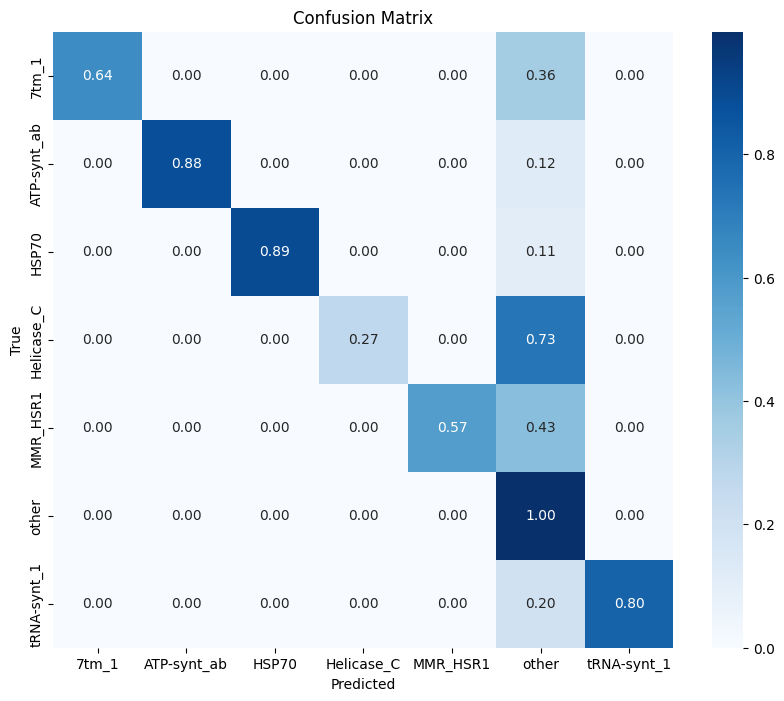

In [5]:
cm = confusion_matrix(y_test, y_pred, normalize='true')
classes = sorted(ds.data['label'].unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Using XGBoost

In [6]:
import xgboost as xgb

encoder = LabelEncoder().fit(ds.data['label'])
y_train_enc = encoder.transform(y_train)
y_test_enc = encoder.transform(y_test)

clf = xgb.XGBClassifier(n_estimators=500, max_depth=10, learning_rate=0.01, n_jobs=8, verbosity=0)
clf.fit(X_train, y_train_enc)

y_pred_enc = clf.predict(X_test)
print(classification_report(y_test_enc, y_pred_enc, zero_division=0))
print(f"Balanced accuracy: ", balanced_accuracy_score(y_test_enc, y_pred_enc))

              precision    recall  f1-score   support

           0       0.94      0.70      0.80       331
           1       0.98      0.90      0.93       357
           2       0.98      0.88      0.93       198
           3       0.98      0.41      0.58       241
           4       0.98      0.67      0.80       352
           5       0.99      1.00      0.99     45566
           6       0.96      0.84      0.90       251

    accuracy                           0.99     47296
   macro avg       0.97      0.77      0.85     47296
weighted avg       0.99      0.99      0.99     47296

Balanced accuracy:  0.7701878086914296


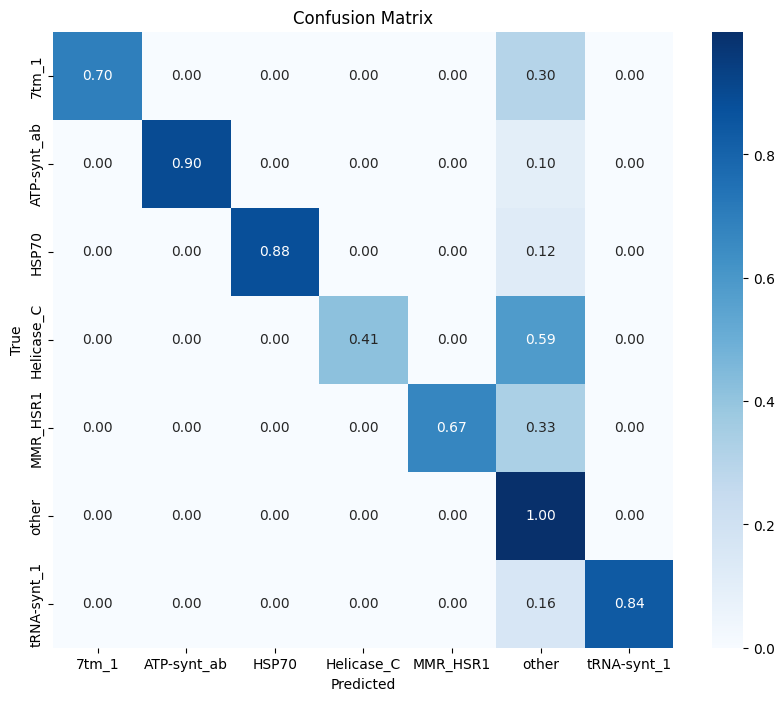

In [7]:
cm = confusion_matrix(y_test_enc, y_pred_enc, normalize='true')
classes = sorted(ds.data['label'].unique())
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()